In [1]:
import pickle
from itertools import product
from functools import reduce
from collections import defaultdict

results = pickle.load(open('../final.pckl', 'rb'))
results = sorted(results, key=lambda el: 'zzzz' if el['encoding'] == 'mono' else el['encoding'] + el['polygraph'])

In [2]:
read_percentages = [50, 75, 90]
polygraph_sizes = range(100, 301, 50)
polygraph_dir = 'polygraphs/workloads3'

polygraphs = [f'{polygraph_dir}/chengR{read_percent}-{size}.polyg'
                for size, read_percent in product(polygraph_sizes, read_percentages)]

In [3]:
def total_time(timings):
    return reduce(lambda total, key: total + timings[key], timings, 0)

def results_by_encoding_for_percent(results, read_percent):
    encodings = reduce(lambda s, item: s | {item['encoding']}, results, set())
    by_encoding = defaultdict(list)
    for size in polygraph_sizes:
        for result in results:
            if result['polygraph'] == f'{polygraph_dir}/chengR{read_percent}-{size}.polyg':
                by_encoding[result['encoding']].append(total_time(result['result'][1]))
    
    return by_encoding

In [4]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
from cycler import cycler

In [5]:
def plot_by_encoding_for_percent(results, read_percent=50, encodings=[], exclude=True):
    fig, ax = plt.subplots(figsize=(12, 12))

    rows = results_by_encoding_for_percent(results, read_percent)
    default_colors = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    ax.set_prop_cycle(default_colors * cycler(linestyle=['-', '--', ':',]))
    
    for enc in rows:
        # XOR
        if bool(enc in encodings) != exclude: 
            timing = np.pad(rows[enc], (0, 5 - len(rows[enc])), 'constant', constant_values=(math.inf))
            ax.scatter(polygraph_sizes, timing, )
            ax.plot(polygraph_sizes, timing, label=enc)
    
    ax.set_yscale('log')
    ax.legend()

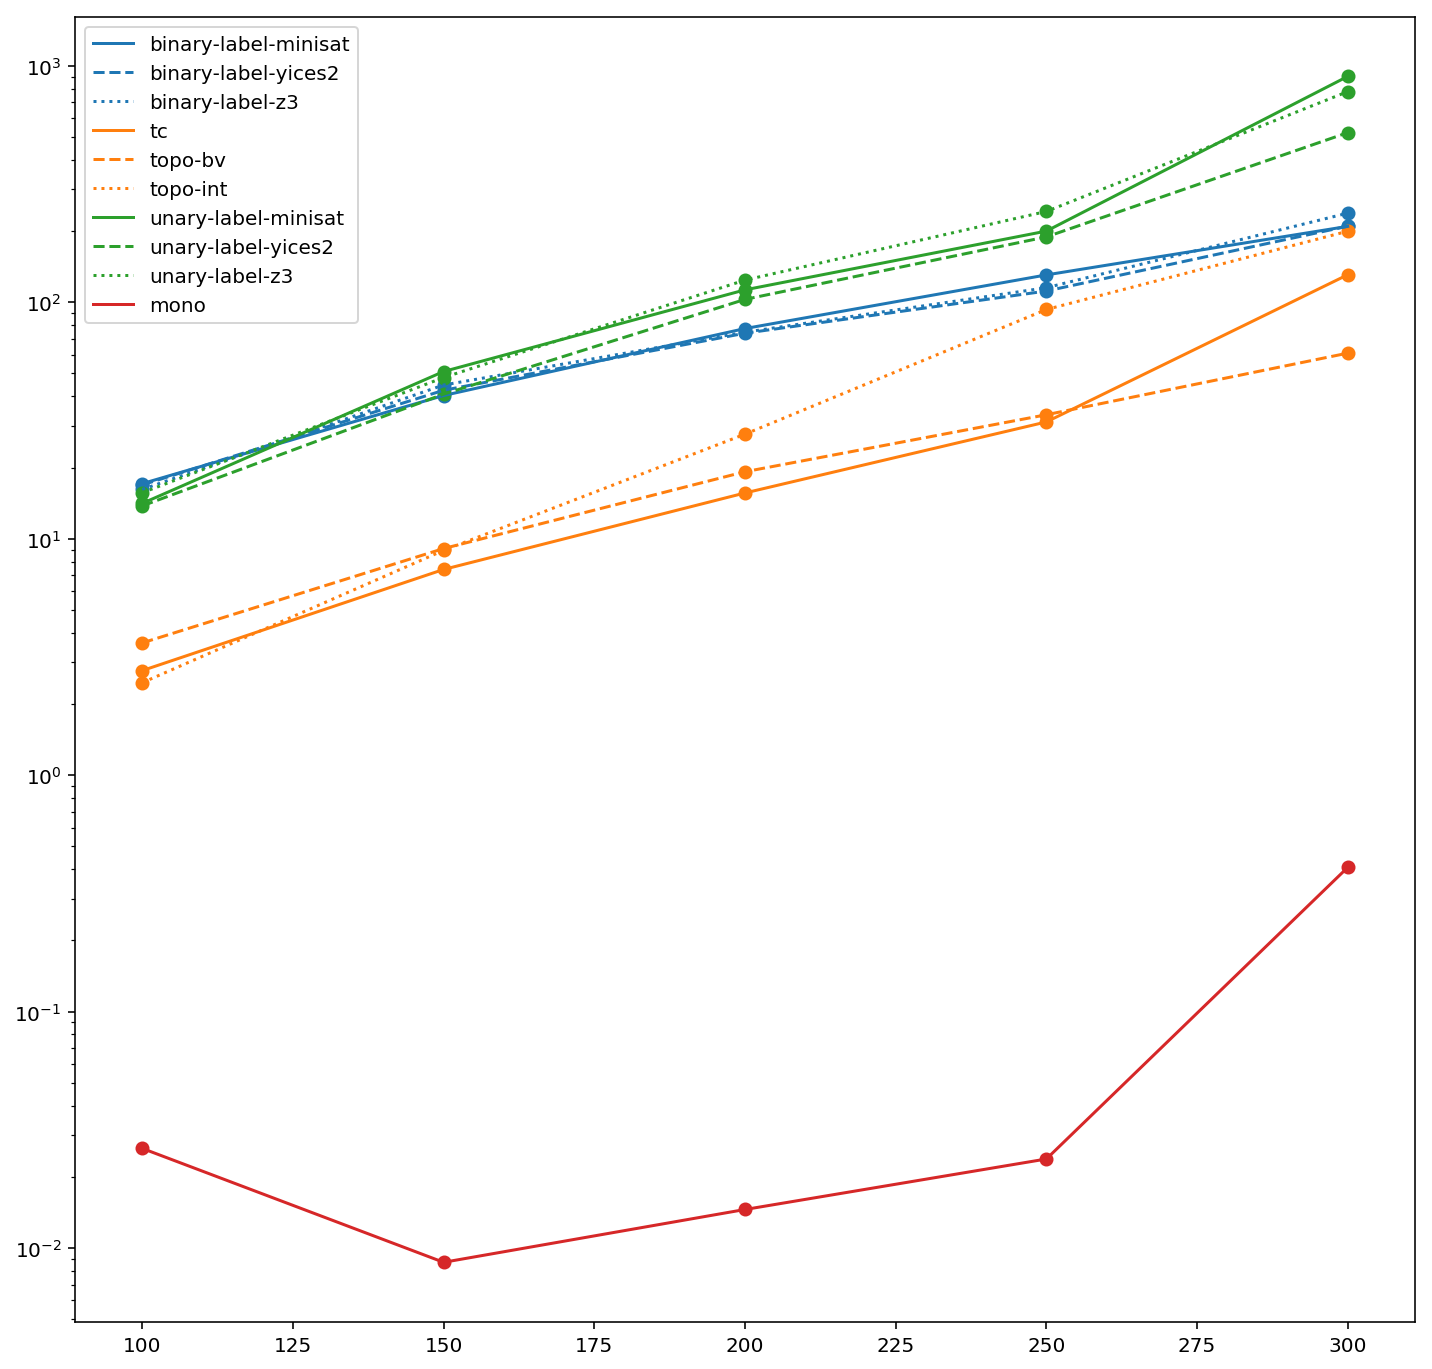

In [6]:
plot_by_encoding_for_percent(results, 50, ['tc1', 'tc3', 'tree-bv', 'axiom'])

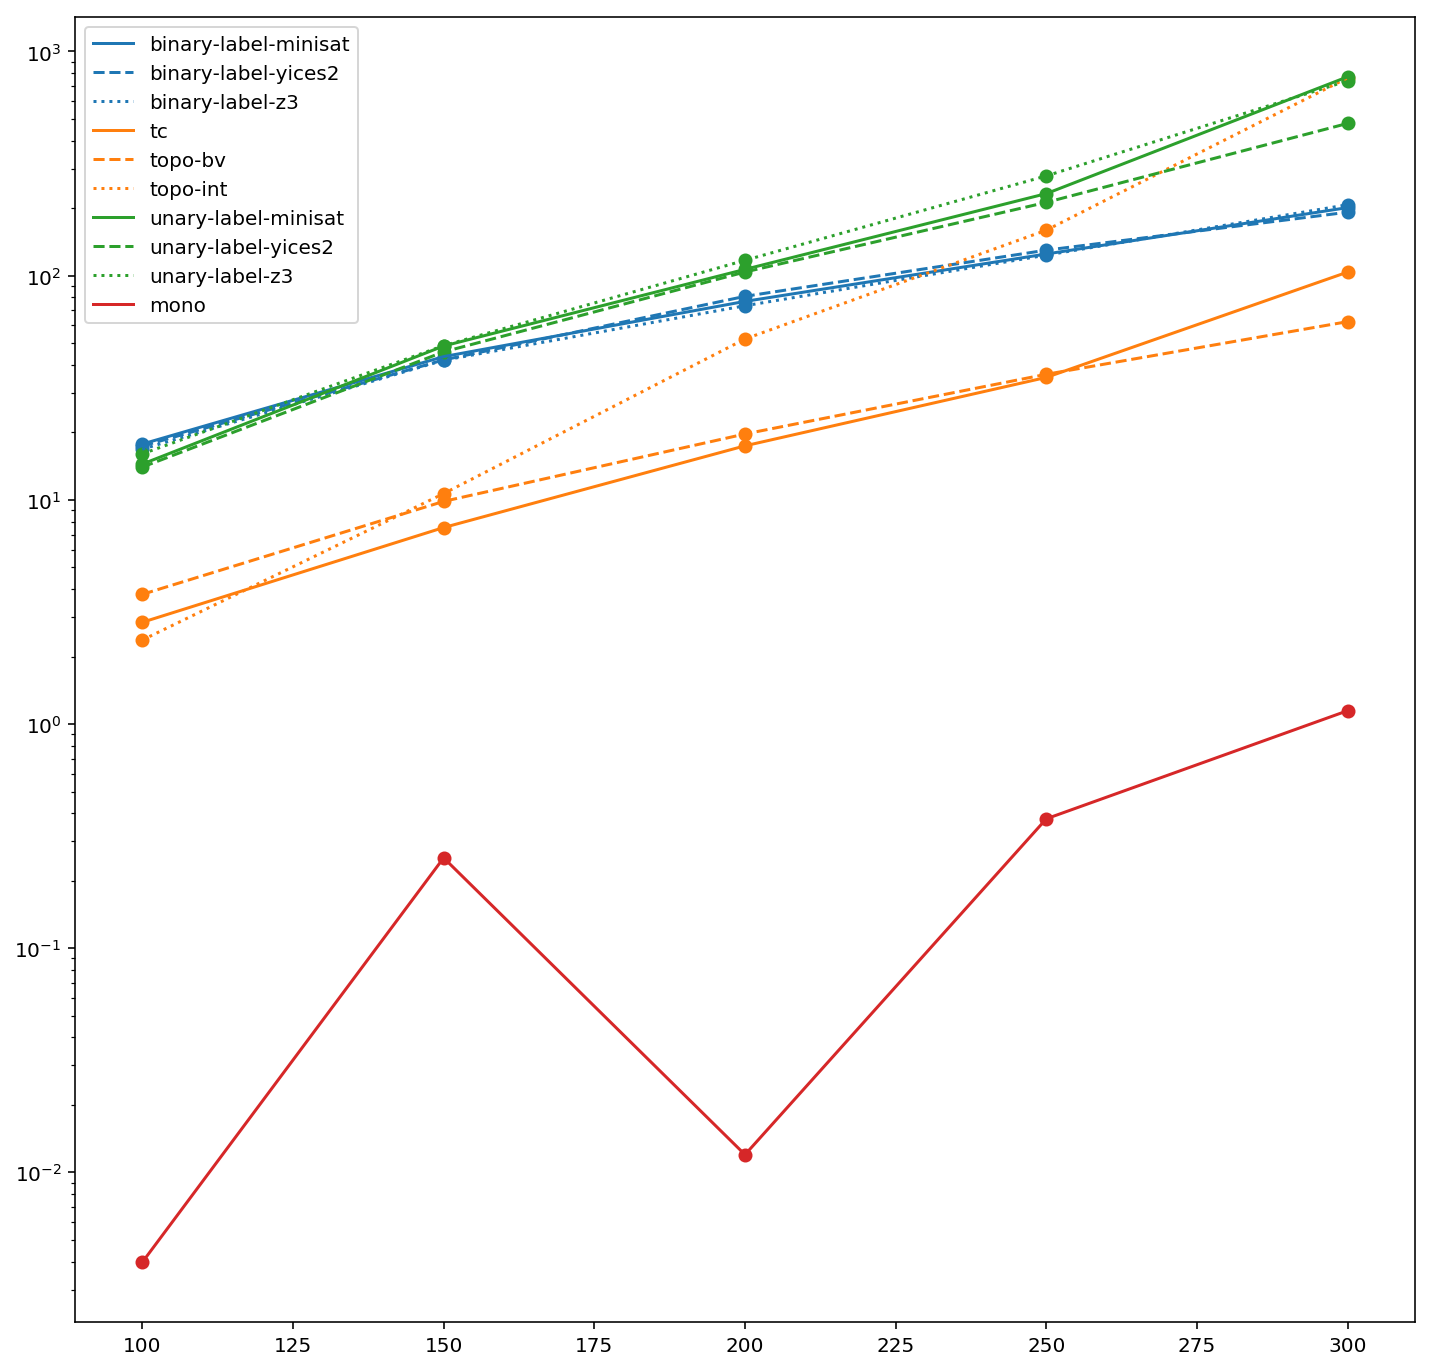

In [7]:
plot_by_encoding_for_percent(results, 75, ['tc1', 'tc3', 'tree-bv', 'axiom'])

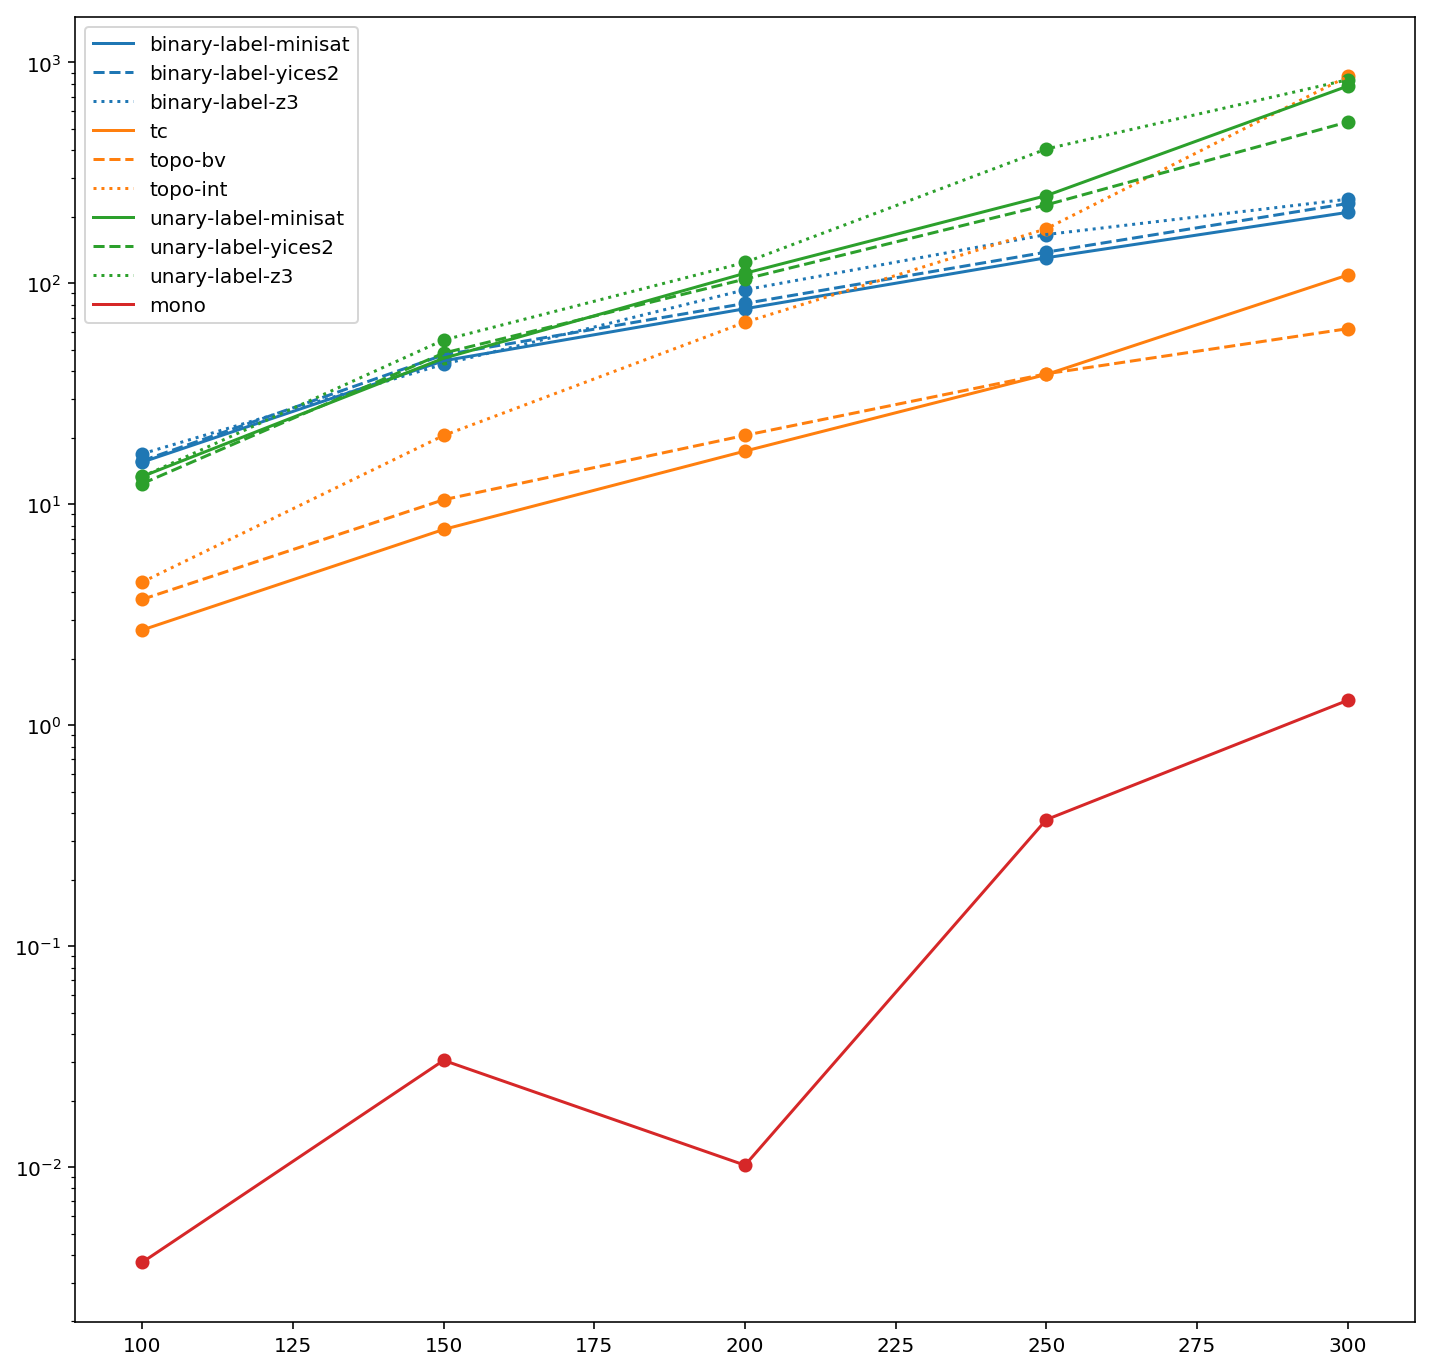

In [8]:
plot_by_encoding_for_percent(results, 90, ['tc1', 'tc3', 'tree-bv', 'axiom'])

In [9]:
def by_encoding(results, encoding):
    output = []
    
    for percent in read_percentages:
        rows = results_by_encoding_for_percent(results, percent)
        output.append(rows[encoding])
    
    return output

In [10]:
def plot_encoding(results, encoding):
    fig, ax = plt.subplots(figsize=(12, 12))
    rows = by_encoding(results, encoding)
    for row in rows:
        timing = np.pad(row, (0, 5 - len(row)), 'constant', constant_values=(math.inf))
        ax.plot(polygraph_sizes, timing)
    ax.legend(read_percentages)
        

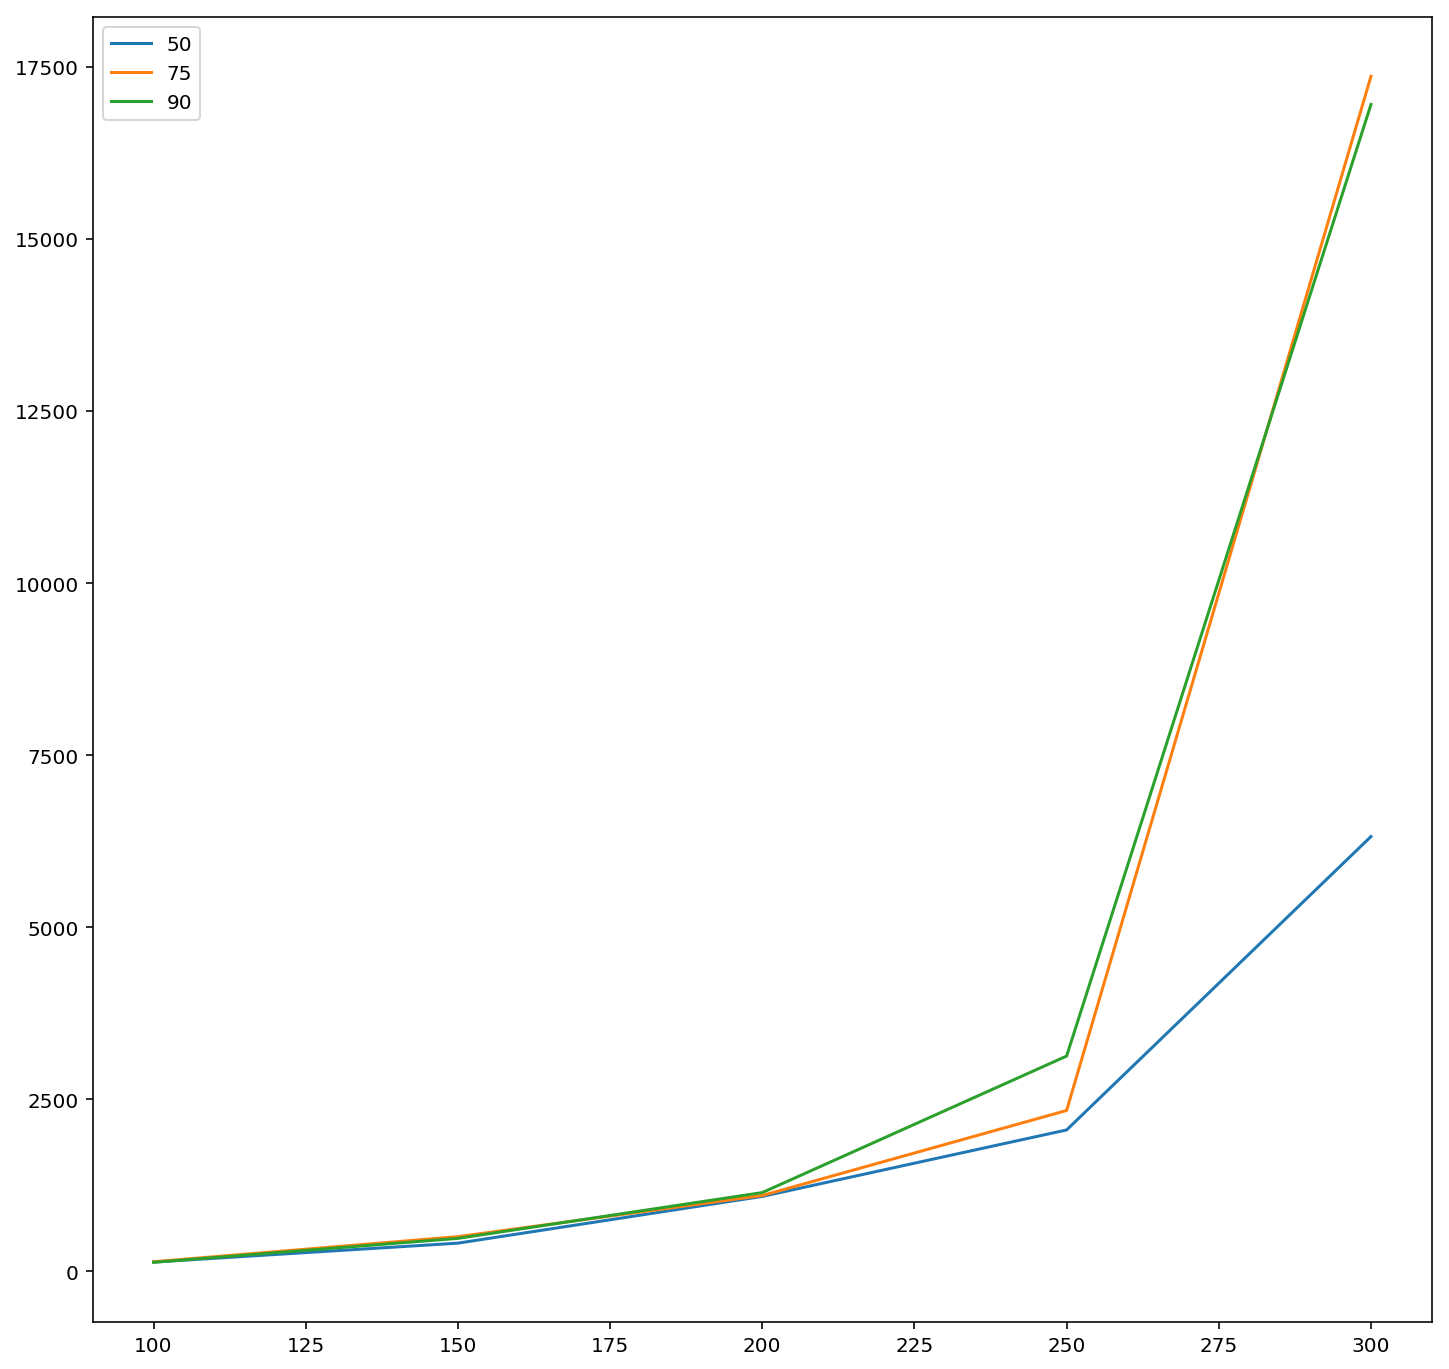

In [11]:
plot_encoding(results, 'tc1')

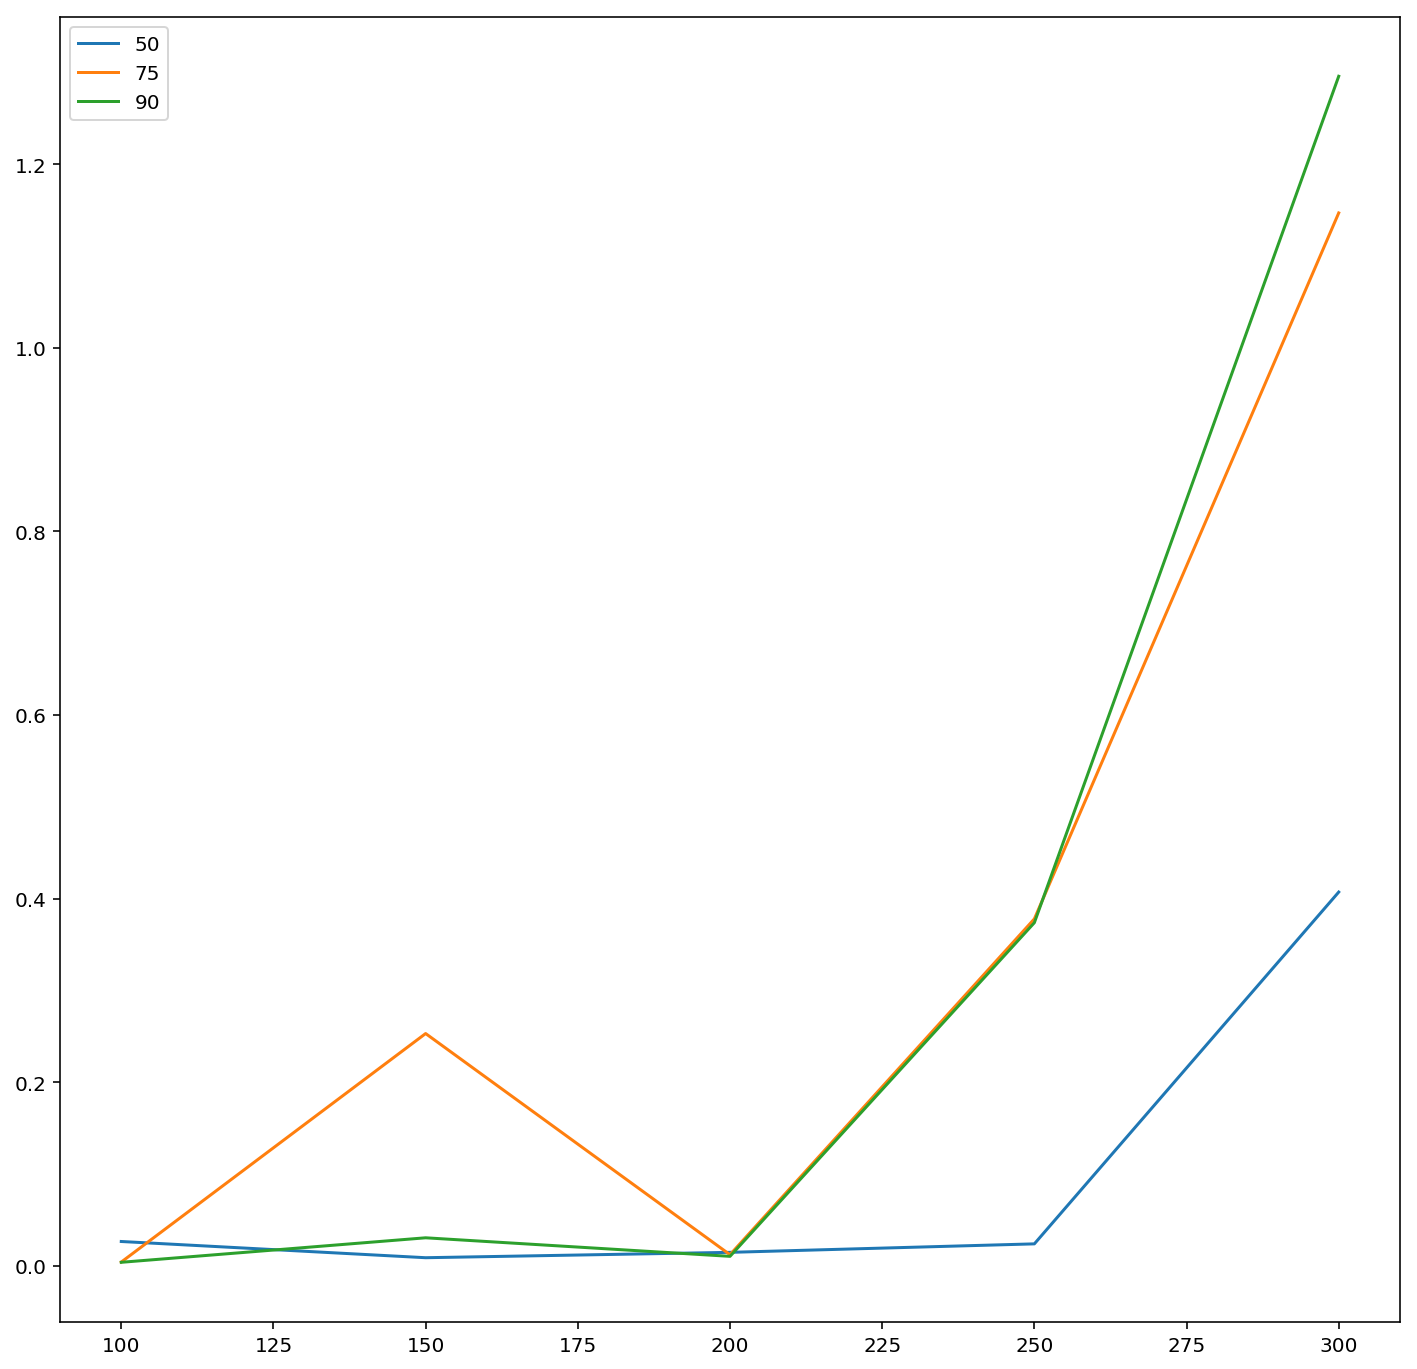

In [12]:
plot_encoding(results, 'mono')

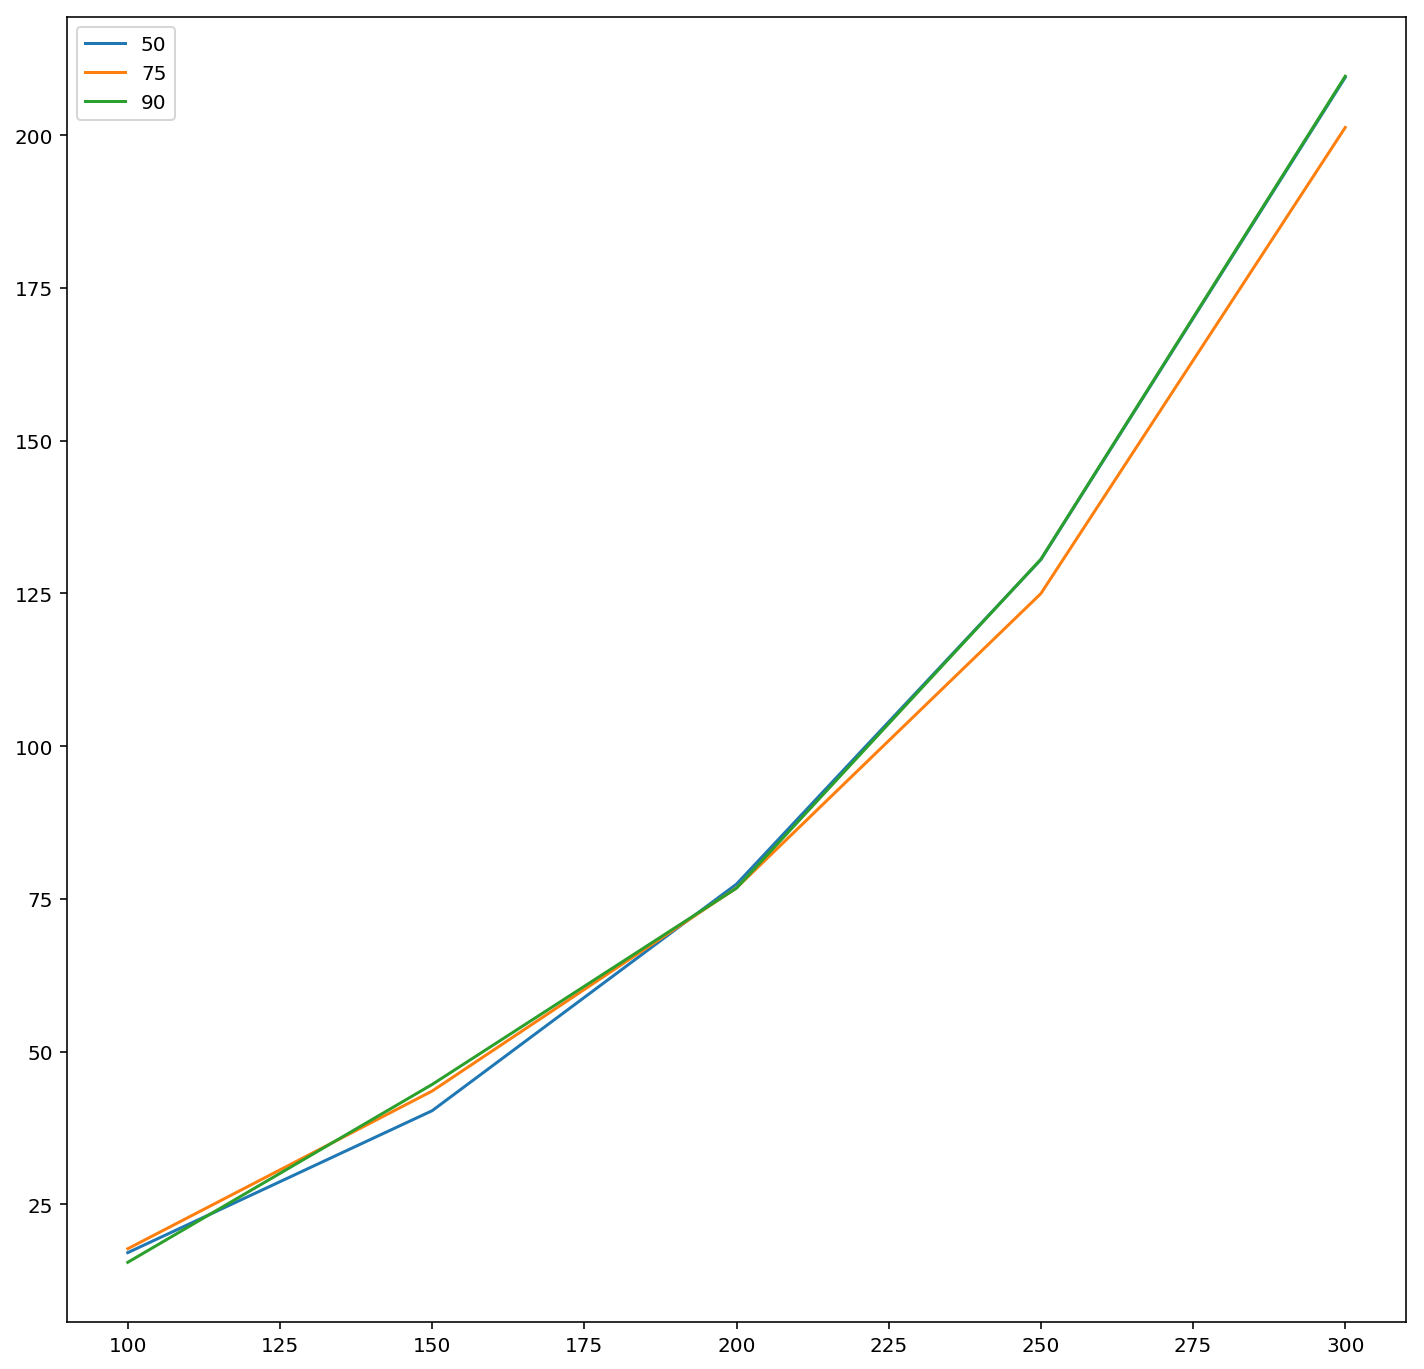

In [13]:
plot_encoding(results, 'binary-label-minisat')

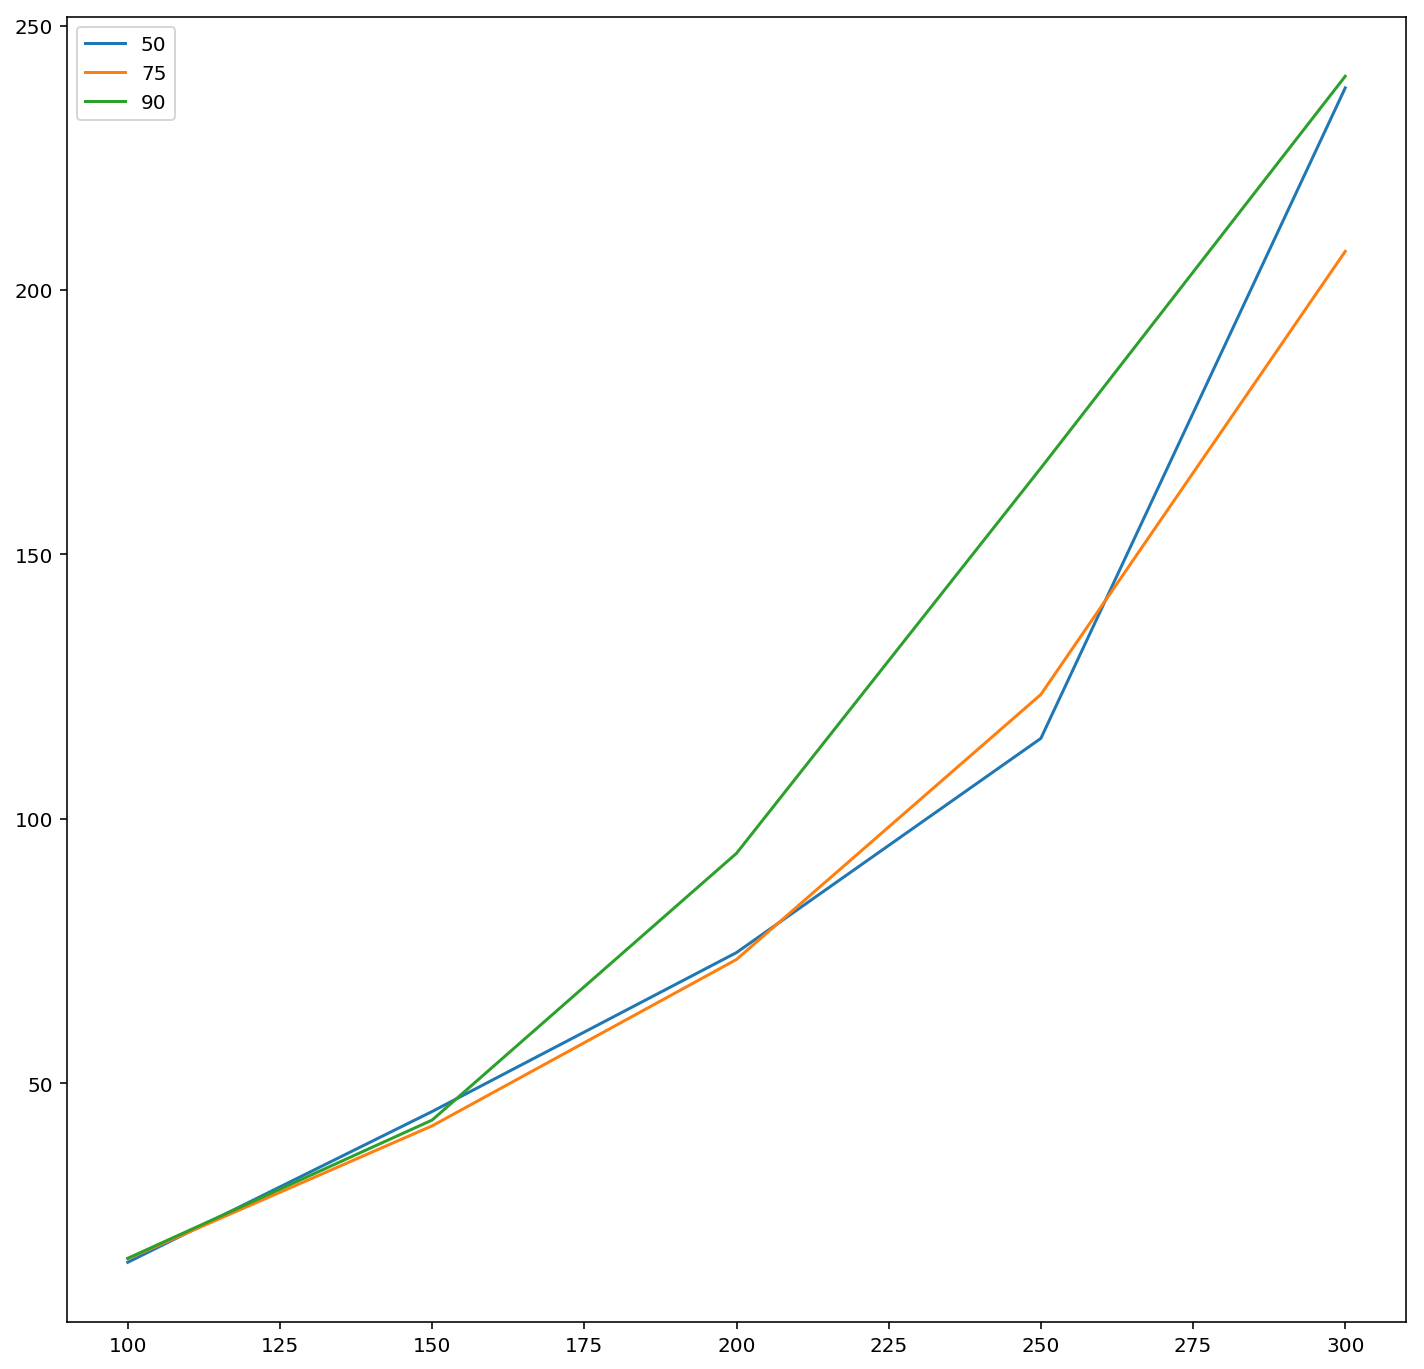

In [14]:
plot_encoding(results, 'binary-label-z3')

In [15]:
def encode_timing_for_percent(results, read_percent, timing):
    encodings = reduce(lambda s, item: s | {item['encoding']}, results, set())
    by_encoding = defaultdict(list)
    for size in polygraph_sizes:
        for result in results:
            if f'chengR{read_percent}-{size}.polyg' in result['polygraph']:
                by_encoding[result['encoding']].append(result['result'][1][timing])
    return by_encoding

In [16]:
def plot_encode_time_for_percent(results, read_percent=50, exclude=[]):
    fig, ax = plt.subplots(figsize=(12, 12))

    rows = encode_timing_for_percent(results, read_percent, 'encode')
    default_colors = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    ax.set_prop_cycle(default_colors * cycler(linestyle=['-', '--', ':',]))
#     cm = plt.get_cmap('gist_rainbow')
#     ax.set_prop_cycle(cycler(color=[cm(1.*i/len(rows)) for i in range(len(rows))]))
    
    for enc in rows:
        if not enc in exclude:
            timing = np.pad(rows[enc], (0, 5 - len(rows[enc])), 'constant', constant_values=(math.inf))
            ax.scatter(polygraph_sizes, timing)
            ax.plot(polygraph_sizes, timing, label=enc)
    
#     ax.set_yscale('log')
    ax.legend()

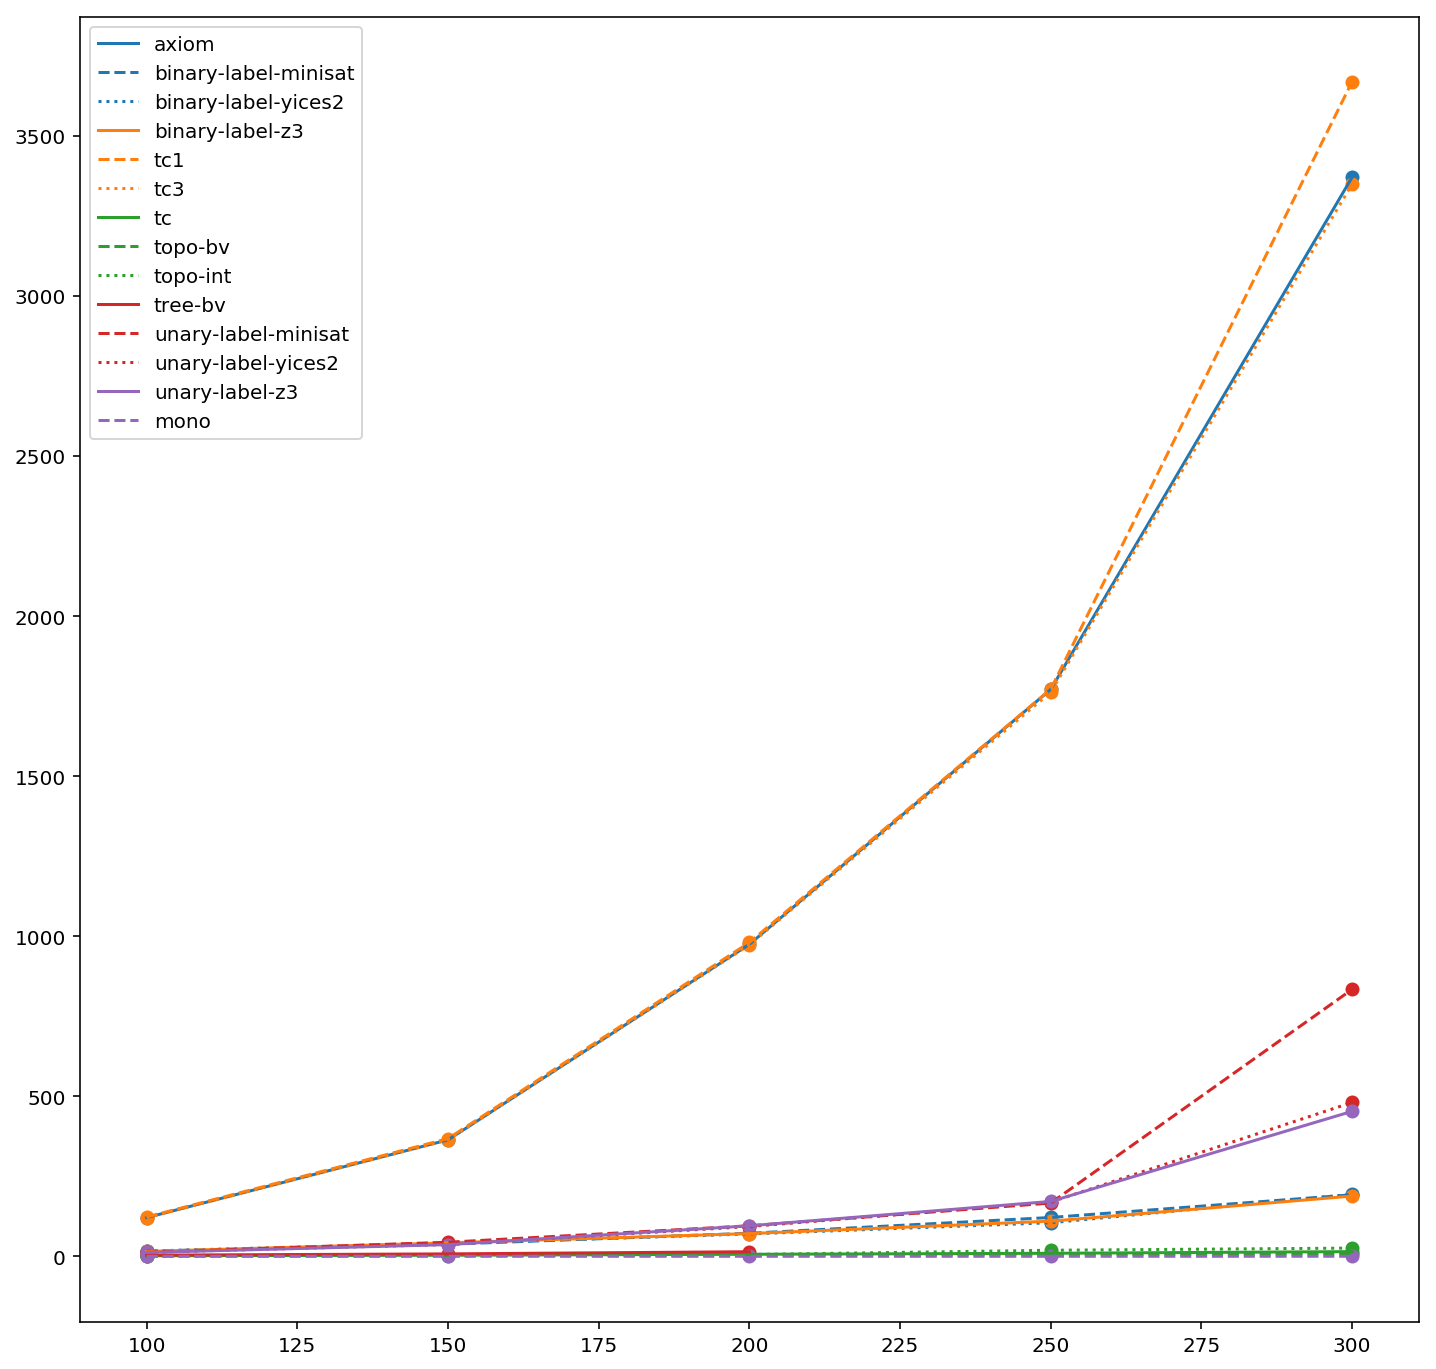

In [17]:
plot_encode_time_for_percent(results, 50)

In [18]:
def plot_solve_time_for_percent(results, read_percent=50, exclude=[]):
    fig, ax = plt.subplots(figsize=(12, 12))

    rows = encode_timing_for_percent(results, read_percent, 'solve')
    default_colors = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    ax.set_prop_cycle(default_colors * cycler(linestyle=['-', '--', ':',]))
#     cm = plt.get_cmap('gist_rainbow')
#     ax.set_prop_cycle(cycler(color=[cm(1.*i/len(rows)) for i in range(len(rows))]))
    
    for enc in rows:
        if not enc in exclude:
            timing = np.pad(rows[enc], (0, 5 - len(rows[enc])), 'constant', constant_values=(math.inf))
            ax.scatter(polygraph_sizes, timing)
            ax.plot(polygraph_sizes, timing, label=enc)
    
#     ax.set_yscale('log')
    ax.legend()

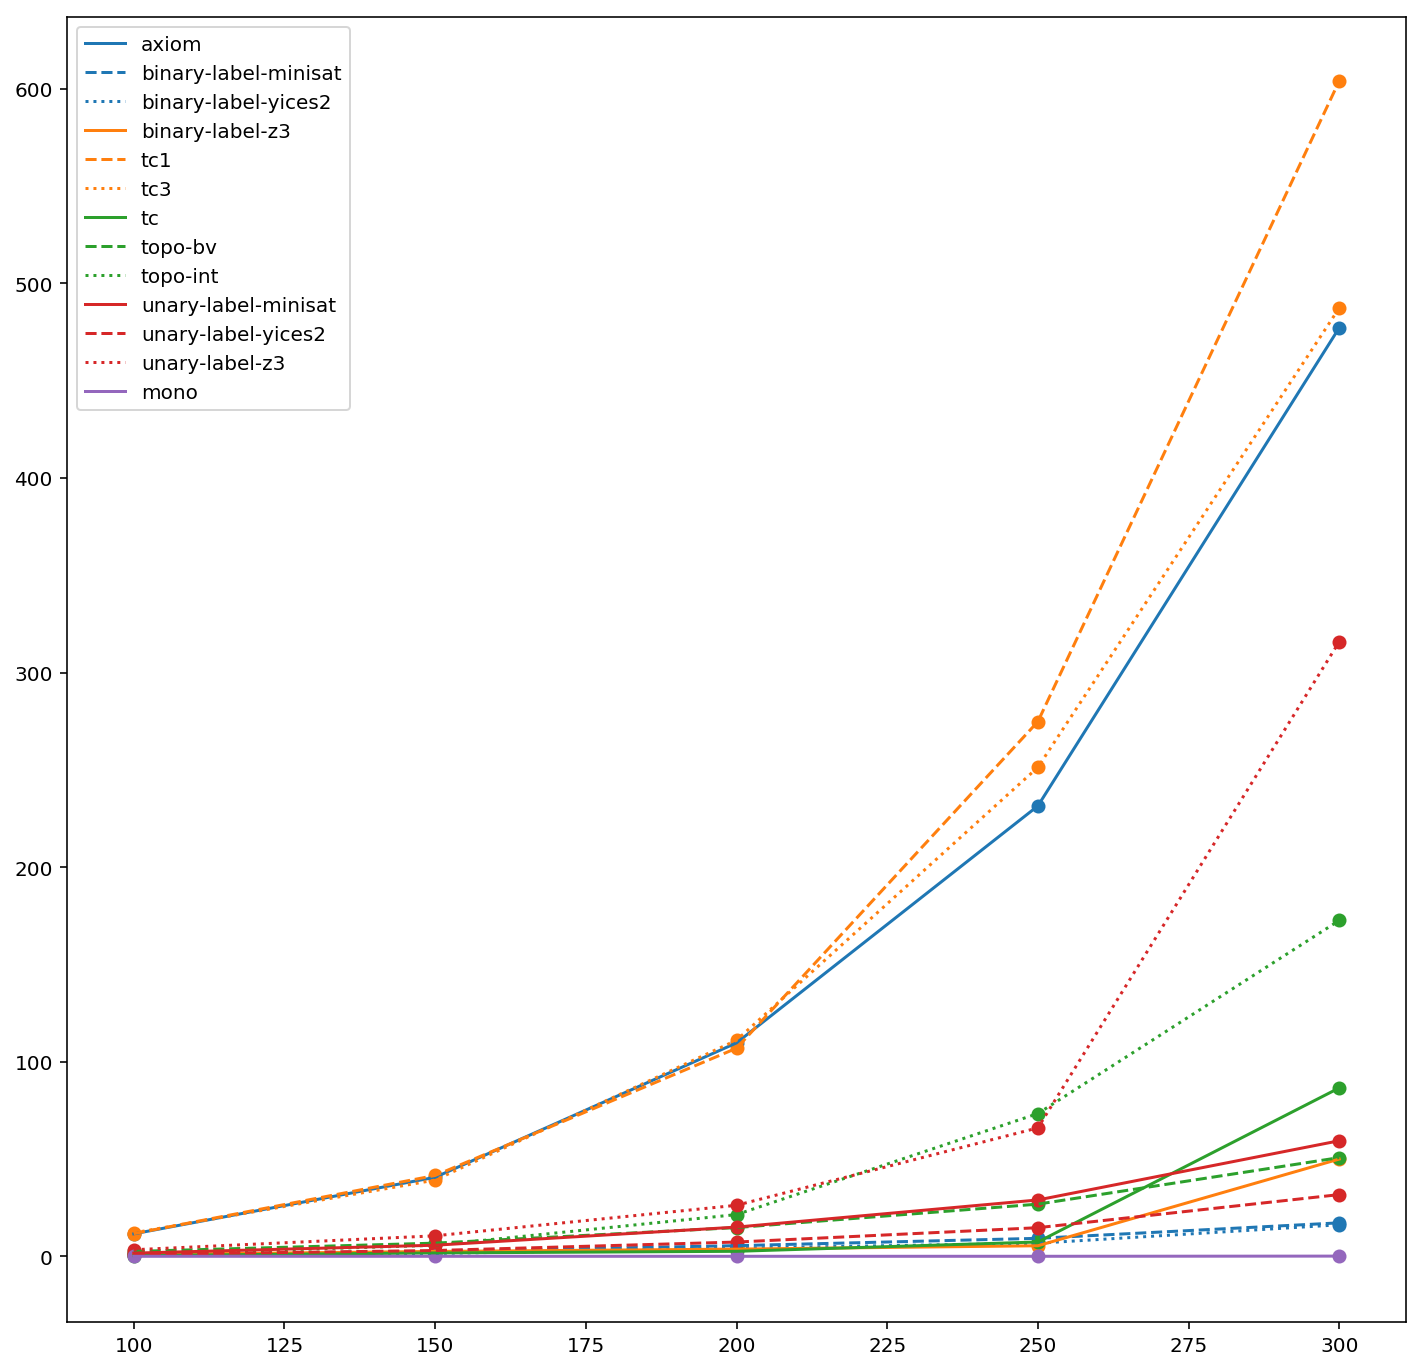

In [19]:
plot_solve_time_for_percent(results, 50, exclude=['tree-bv'])

In [20]:
# number of clauses?

In [21]:
import matplotlib.cm as cm
counts = pickle.load(open('../count.pckl', 'rb'))
sat_vars = ['binary-label', 'unary-label', 'tc1', 'tc3', 'axiom', 'topo-bv']
# {'tc3', 'unary-label', 'binary-label', 'tc1'}

var_counts_and_timings = {}

def has_sat_vars(encoding_name):
    return any([sv in encoding_name for sv in sat_vars])
    
def plot_sat_vars_solves(results, counts):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    timings_y = []
    encodings = {}
    var_counts_x = defaultdict(list)
    solve_time_y = defaultdict(list)
    
    for row in results:
        enc = row['encoding']
        polyg = row['polygraph']

        if has_sat_vars(enc):
            count_enc = enc
            if 'binary-label' in enc:
                count_enc = 'binary-label-minisat'
            elif 'unary-label' in enc:
                count_enc = 'unary-label-minisat'
            
            encodings[count_enc] = True
            
            var_counts_x[count_enc].append(int(counts[(count_enc, polyg)]['var']))
            solve_time_y[count_enc].append(total_time(row['result'][1]))
    
    for encoding in encodings:
        ax.scatter(var_counts_x[encoding], solve_time_y[encoding])
    
    ax.set_xscale('log')
    ax.legend(encodings.keys())
    
# def plot_sat_vars(results, var_counts):
#     fig, ax = plt.subplots(figsize=(12, 12))
    
#     var_counts_x = []
#     timings_y = []
#     encodings = []
    
#     for row in results:
#         enc = row['encoding']
#         polyg = row['polygraph']

#         if has_sat_vars(enc):
#             count_enc = enc
#             if 'binary-label' in enc:
#                 count_enc = 'binary-label-minisat'
#                 encodings.append('binary-label')
#             elif 'unary-label' in enc:
#                 count_enc = 'unary-label-minisat'
#                 encodings.append('unary-label')
#             else:
#                 encodings.append(enc)
#             var_counts_x.append(int(counts[(count_enc, polyg)]['var']))
#             timings_y.append((total_time(row['result'][1])))
        
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     print(set(encodings))

#     enc_to_c = lambda enc: cm.rainbow(np.linspace(0, 1, len(set(encodings))))[list(set(encodings)).index(enc)]
#     ax.scatter(var_counts_x, timings_y, c=list(map(enc_to_c, encodings)), s=8)

In [22]:
plot_sat_vars(results, counts)

NameError: name 'plot_sat_vars' is not defined

In [ ]:
plot_by_encoding_for_percent(results, 50, ['binary-label-minisat', 'binary-label-z3', 'binary-label-yices2'], False)

In [ ]:
plot_by_encoding_for_percent(results, 50, ['unary-label-minisat', 'unary-label-z3', 'unary-label-yices2'], False)

In [ ]:
plot_by_encoding_for_percent(results, 50, ['tree-bv'])

In [ ]:
def plot_sat_vars_solves(results, counts):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    timings_y = []
    encodings = {}
    var_counts_x = defaultdict(list)
    solve_time_y = defaultdict(list)
    
    for row in results:
        enc = row['encoding']
        polyg = row['polygraph']

        if has_sat_vars(enc):
            count_enc = enc
            if 'binary-label' in enc:
                count_enc = 'binary-label-minisat'
            elif 'unary-label' in enc:
                count_enc = 'unary-label-minisat'
            
            encodings[count_enc] = True
            
            var_counts_x[count_enc].append(int(counts[(count_enc, polyg)]['var']))
            solve_time_y[count_enc].append(row['result'][1]['solve'])
    
    for encoding in encodings:
        ax.scatter(var_counts_x[encoding], solve_time_y[encoding])
    
    ax.set_xscale('log')
    ax.legend(encodings.keys())

In [ ]:
# TODO: how to interpret log scale graphs?
plot_sat_vars_solves(results, counts)

In [ ]:
plot_by_encoding_for_percent(results, 75, ['binary-label-minisat', 'binary-label-z3', 'binary-label-yices2'], False)